In [11]:
import tensorflow as tf
import numpy as np
import os
import random


In [12]:

print('num gpus', len(tf.config.list_physical_devices('GPU')))

Seed = 123456
os.environ['PYTHONHASHSEED'] = str(Seed)  # Corrigido de 'phytonhashseed' para 'PYTHONHASHSEED'
random.seed(Seed)
np.random.seed(Seed)
tf.random.set_seed(Seed)


num gpus 0


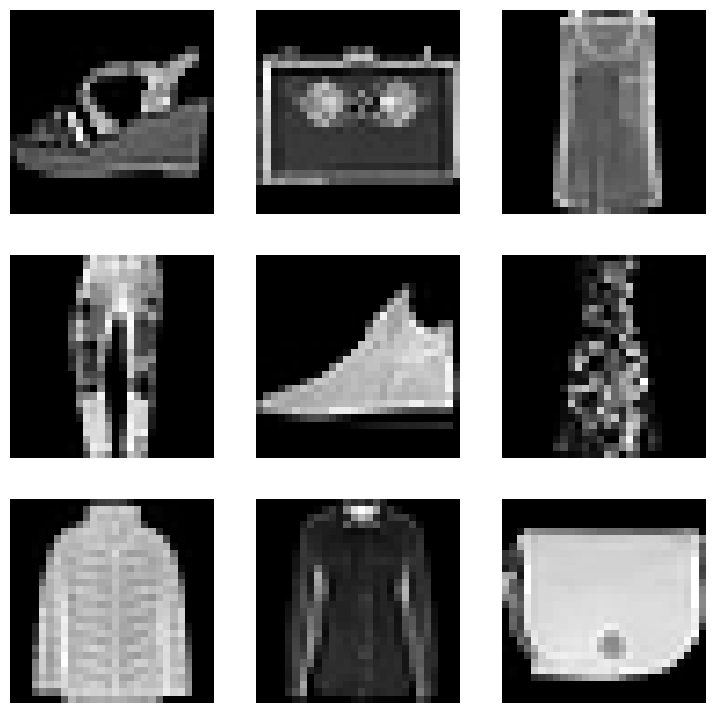

In [13]:

from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

from matplotlib import pyplot as plt
plt.figure(figsize=(9, 9))
rnd_sample = np.random.choice(60000, 9)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[rnd_sample[i]], cmap='gray')  # Corrigido para mostrar as imagens aleatórias selecionadas
    plt.axis('off')
plt.show()

In [14]:

dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, axis=-1).astype(np.float32) / 255

from tensorflow.keras import Layer
from tensorflow import keras

class SamplingLayer(Layer):
    def call(self, inputs):
        zMean, zLogVar = inputs
        batch = tf.shape(zMean)[0]
        dim = tf.shape(zMean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [15]:
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout

def buildEncoder(latentDim, encoderInputs):
    l1 = Sequential([
        Conv2D(128, 3, activation='relu', strides=2, padding='same'),
        Dropout(0.3),
        Conv2D(64, 3, activation='relu', strides=2, padding='same'),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3)  # Adicionada a vírgula que faltava
    ])  # cria o encoder com duas camadas de convolução para extração de características e uma camada densa com 256 nodos para transformá-las em um vetor

    x = l1(encoderInputs)

    zMean = Dense(latentDim, name='z_mean')(x)
    zLogVar = Dense(latentDim, name='z_log_var')(x)
    z = SamplingLayer()([zMean, zLogVar])  # Variáveis necessárias para disponibilizar o vetor latente em uma distribuição probabilística

    return Model(encoderInputs, [zMean, zLogVar, z], name='encoder')

encoderInputs = Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 256)       │    878,144 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer_3    │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (SamplingLayer)     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from keras.layers import Reshape, Conv2DTranspose

def buildDecoder(latentInputs):
    l1 = Sequential([
        Dense(7 * 7 * 64, activation='relu', input_shape=(latentInputs.shape[1],)),
        Dropout(0.3),
        Reshape((7, 7, 64)),
        Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
        Dropout(0.3),
        Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
        Dropout(0.3),
        Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
    ])  # Inicia com um vetor denso para interpretar o vetor latente, seguido de 2 camadas de convolução para aumentar a resolução e uma com apenas um nodo para transformar a saída em uma única camada de pixels

    return Model(latentInputs, l1(latentInputs), name='decoder')

latentInputs = Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 28, 28, 1)      │       157,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from keras.losses import binary_crossentropy

def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            binary_crossentropy(data, reconstructed),
            axis=(1, 2)
        )
    )

def klDivergenceLoss(zMean, zLogVar):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
            axis=1
        )
    )

def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(zMean, zLogVar)
    klWeight = 3.0
    return loss1, loss2, loss1 + klWeight * loss2

from keras.metrics import Mean

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.totalLossTracker = Mean(name='total_loss')
        self.ceLossTracker = Mean(name='ce_loss')
        self.klLossTracker = Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)

        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return {
            'total_loss': self.totalLossTracker.result(),
            'ce_loss': self.ceLossTracker.result(),
            'kl_loss': self.klLossTracker.result()
        }

In [18]:








from keras.optimizers import Adam

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=12, batch_size=128)



Epoch 1/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - ce_loss: 350.2017 - kl_loss: 2.7679 - total_loss: 358.5053
Epoch 2/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - ce_loss: 265.9998 - kl_loss: 4.5055 - total_loss: 279.5162
Epoch 3/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - ce_loss: 261.7637 - kl_loss: 4.6657 - total_loss: 275.7606
Epoch 4/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - ce_loss: 259.7547 - kl_loss: 4.7412 - total_loss: 273.9784
Epoch 5/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - ce_loss: 258.4398 - kl_loss: 4.8104 - total_loss: 272.8710
Epoch 6/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - ce_loss: 257.4380 - kl_loss: 4.8340 - total_loss: 271.9400
Epoch 7/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - ce_loss: 256.5910 - kl_loss: 4.9006 - total_loss: 271.2927
Epoch 8/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - ce_loss: 256.0377 - kl_loss: 4.9248 - total_loss: 270.8122
Epoch 9/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - ce_loss: 255.3086 - kl_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


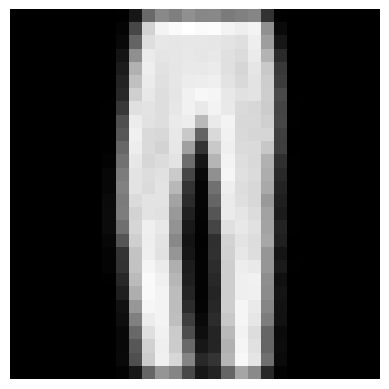

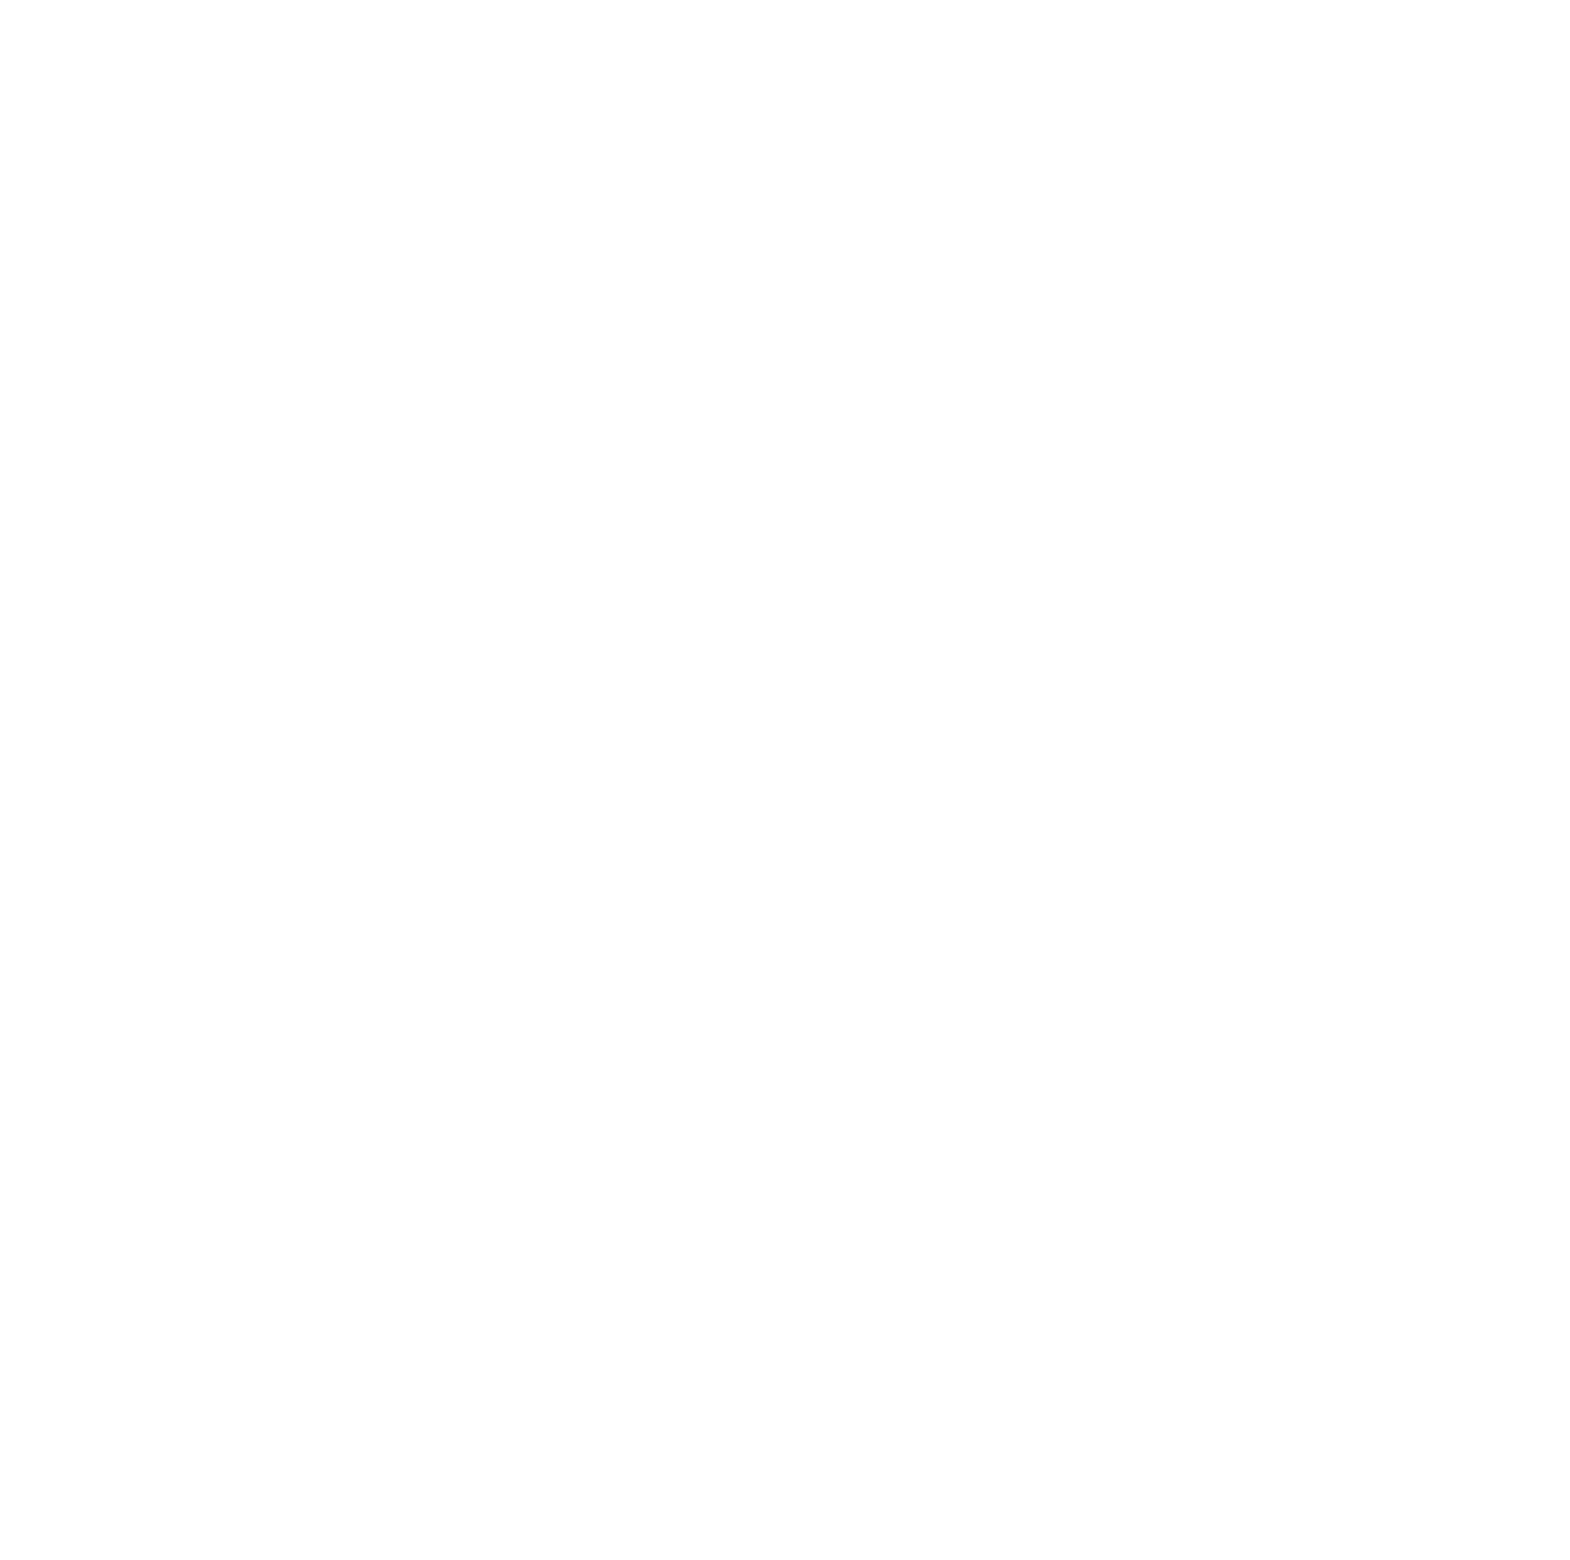

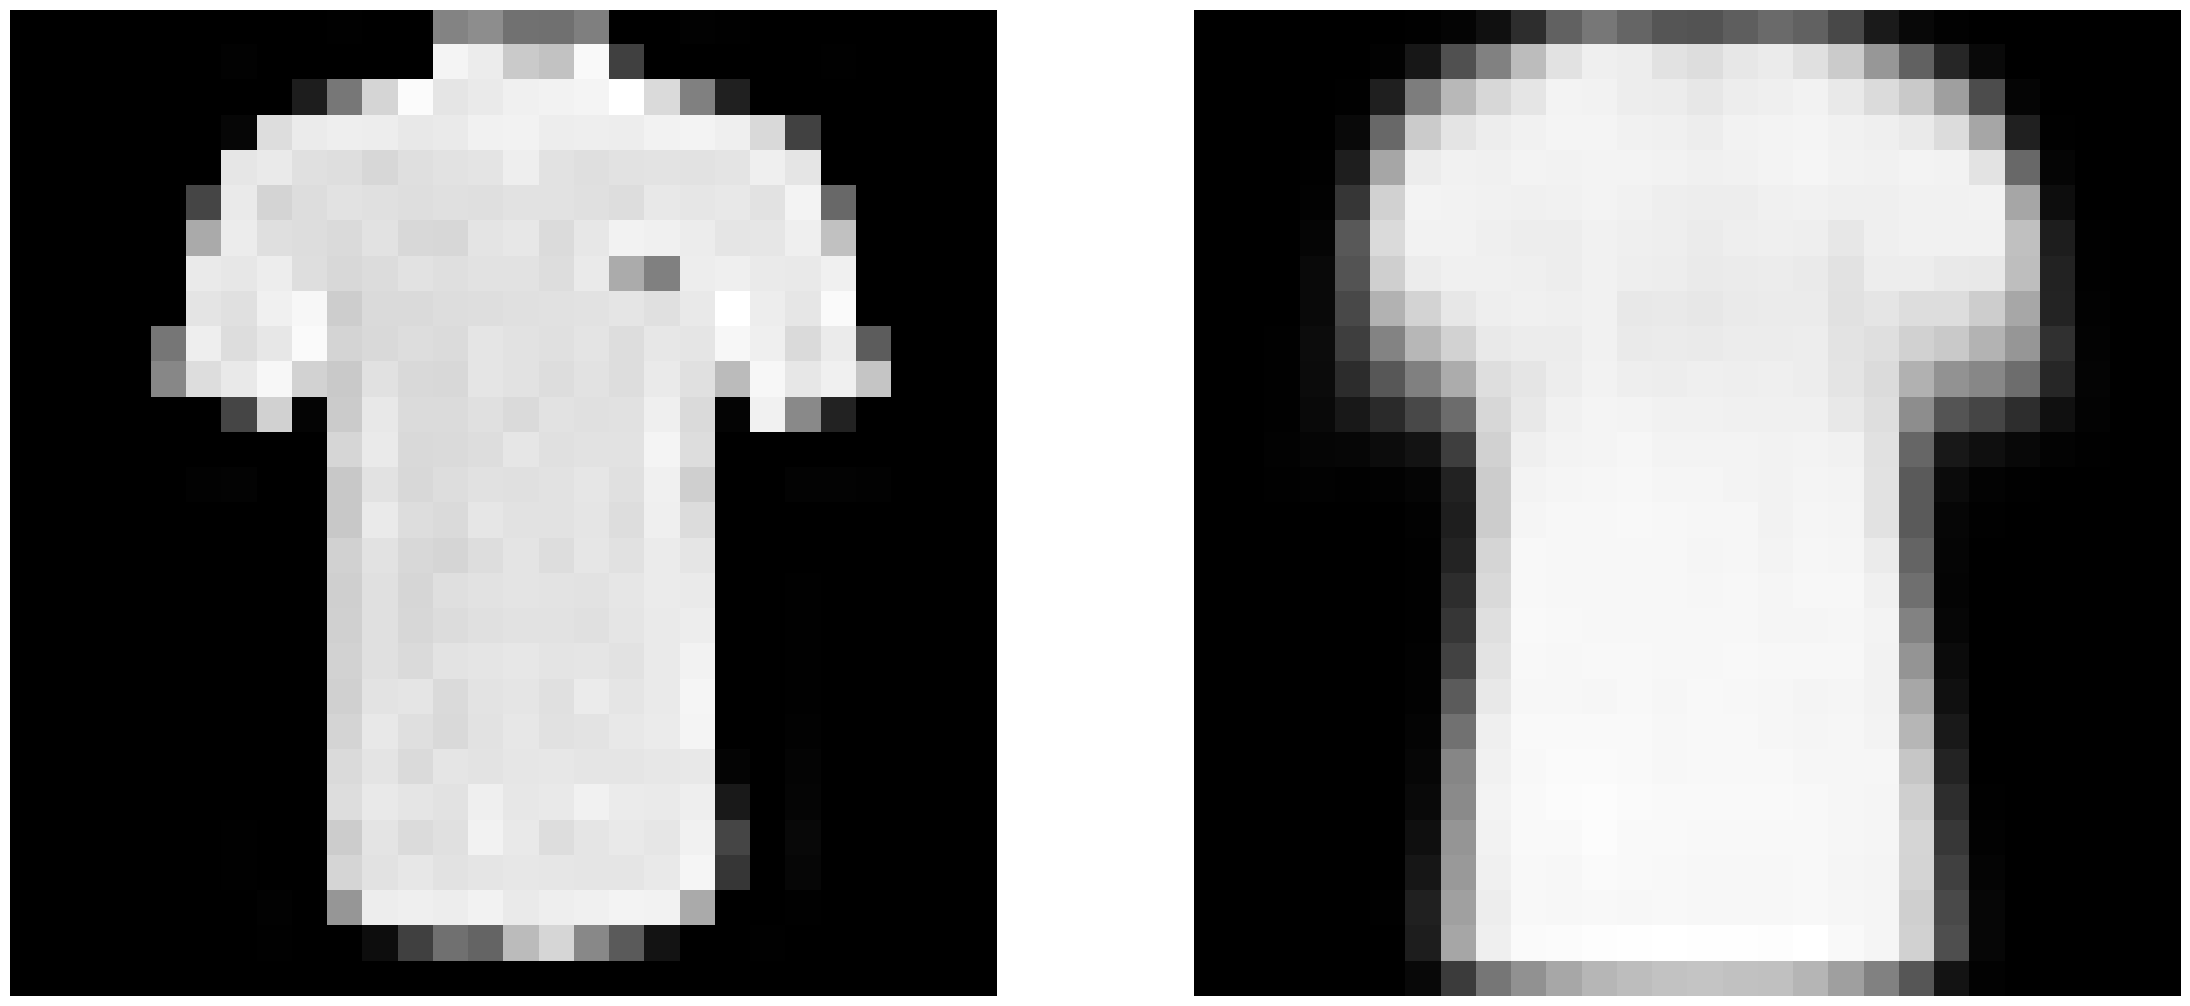

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


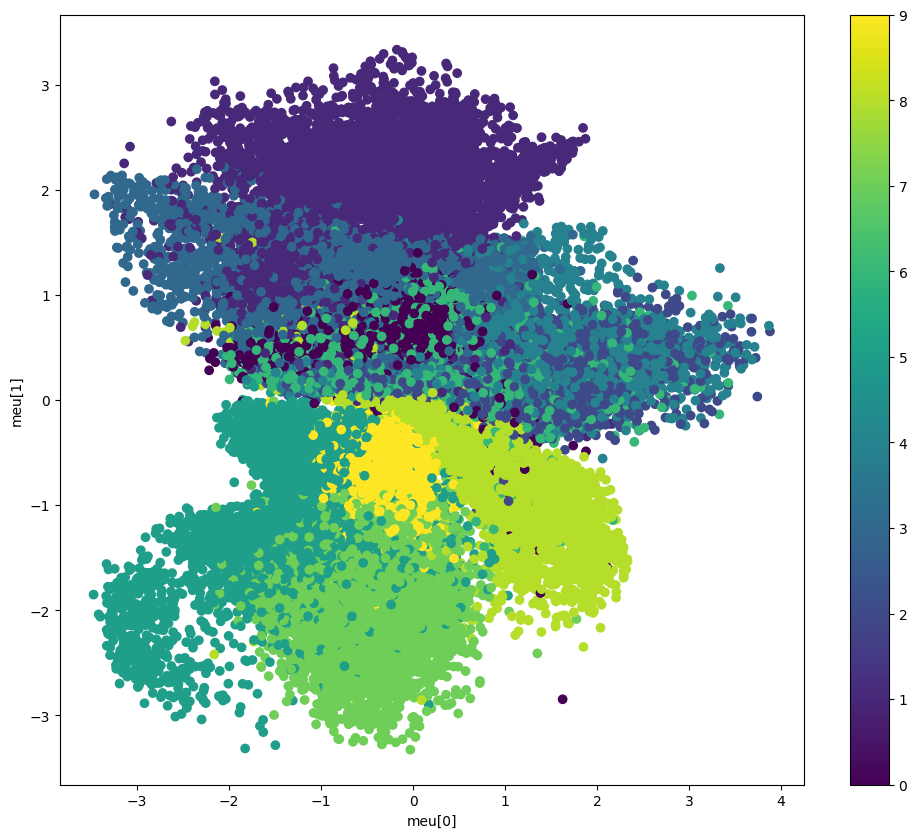

In [20]:
x = np.array([[1, 2]])
synth = vae.decoder.predict(x)  # Gera uma imagem nova utilizando uma predição do decoder
plt.axis('off')
plt.imshow(synth.reshape((28, 28)), cmap='gray')

z = np.random.normal(loc=0, scale=4, size=(250, 2))
synth = vae.decoder.predict(z)
plt.figure(figsize=(20, 20))

idx = 1200
batch = np.expand_dims(x_train[idx], axis=0)
batchofimages = np.expand_dims(batch, axis=-1).astype(np.float32) / 255
print(batchofimages.shape)
plt.axis('off')
_, _, z = vae.encoder.predict(batchofimages)
synth = vae.decoder.predict([z])
z

plt.figure(figsize=(28, 28))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_train[idx], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(synth[0].reshape((28, 28)), cmap='Greys_r')

plt.show()  # Comparação entre uma imagem do dataset base e uma imagem gerada pelo VAE

labels = np.concatenate([y_train, y_test], axis=0)

meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel('meu[0]')
plt.ylabel('meu[1]')
plt.show()
